<a href="https://colab.research.google.com/github/therobinkay/gender_bias_2021/blob/main/Journal_Analysis_1_(GitHub).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import all necessary packages

import io
import pandas as pd
import os
import itertools
import numpy as np
import scipy.stats
import time

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import networkx as nx
import random

import math

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!cd "drive/My Drive"

In [4]:
# read all necessary .csv files

data = pd.read_csv("drive/My Drive/codes/data.csv")
dp = pd.read_csv("drive/My Drive/codes/doipacs.csv")
# cdata = pd.read_csv('drive/My Drive/codes/cdata.csv')
cb = pd.read_csv("drive/My Drive/codes/citationBara.csv")
cen = pd.read_csv("drive/My Drive/codes/cen.csv")

# Analyses


## 1. Order of Author Analysis

In [ ]:
# excluding alphabetically sorted papers

# splitting the authors by first, second, middle, last positions

first = data.query('is_alpha == False & order == 1')
second = data.query('is_alpha == False & order == 2 & is_last == False')
middle = data.query('is_alpha == False & order > 2 & is_last == False')
last = data.query('is_alpha == False & order != 1 & is_last == True')

In [ ]:
# calculating gender ratio of each position

print(first['gender'].value_counts(normalize=True))
print(second['gender'].value_counts(normalize=True))
print(middle['gender'].value_counts(normalize=True))
print(last['gender'].value_counts(normalize=True))

male      0.917101
female    0.082899
Name: gender, dtype: float64
male      0.911277
female    0.088723
Name: gender, dtype: float64
male      0.906659
female    0.093341
Name: gender, dtype: float64
male      0.91497
female    0.08503
Name: gender, dtype: float64


## 2. Productivity by Gender


In [5]:
# Creating a DataFrame with productivity calculated
prod = data.groupby(['id', 'gender']).agg({'year': [min, max, 'count']})

prod['career_age'] = prod['year']['max'] - prod['year']['min']
prod['prod'] = prod['year']['count'] / (prod['career_age'])
prod = prod[prod['career_age'] != 0]

prod.sort_values([('year','count')], ascending=False).head()

# Dividing the DataFrame by gender
prod_m = prod.xs('male', level='gender').sort_values(
    by=['prod'],ascending=False, ignore_index=True)
prod_fm = prod.xs('female', level='gender').sort_values(
    by=['prod'],ascending=False)

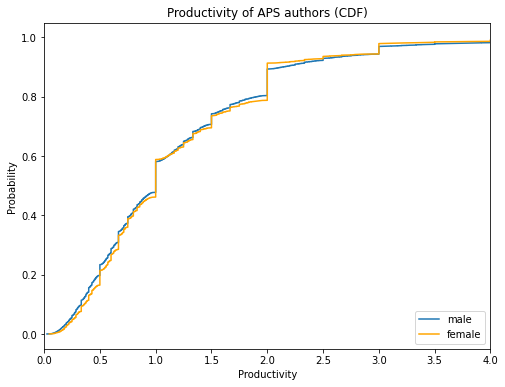

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline
from scipy.interpolate import interp1d

cdf1=np.arange(len(prod_m))/float(len(prod_m)-1)
cdf2=np.arange(len(prod_fm))/float(len(prod_fm)-1)

plt.figure(figsize=(8,6))
plt.plot(prod_m['prod'],1-cdf1)
plt.plot(prod_fm['prod'],1-cdf2, color='orange')

plt.title('Productivity of APS authors (CDF)')
plt.xlabel('Productivity')
plt.xlim(xmin=0, xmax=4)
plt.ylabel('Probability')
plt.legend(['male', 'female'], loc='lower right')
# plt.ylim(ymin=0, ymax=0.5)

plt.show()

In [ ]:
#ks test (two-tailed)
from scipy.stats import ks_2samp
print(ks_2samp(prod_m['prod'], prod_fm['prod']))

#ks test: male > female
print(ks_2samp(prod_m['prod'], prod_fm['prod'], alternative='greater'))

#ks test: male < female
print(ks_2samp(prod_m['prod'], prod_fm['prod'], alternative='less'))

Ks_2sampResult(statistic=0.0329418537762845, pvalue=0.000127997328482532)
Ks_2sampResult(statistic=0.0329418537762845, pvalue=6.244757804870422e-05)
Ks_2sampResult(statistic=0.019882369577186365, pvalue=0.029229651385167425)


In [ ]:
# finding where the biggest difference occurs

def ks_2samp_x(data1, data2, alternative="two-sided"):
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1 = data1.shape[0]
    n2 = data2.shape[0]

    data_all = np.concatenate([data1, data2])
    # using searchsorted solves equal data problem
    cdf1 = np.searchsorted(data1, data_all, side='right') / n1
    cdf2 = np.searchsorted(data2, data_all, side='right') / n2
    cddiffs = cdf1 - cdf2
    minS = np.argmin(cddiffs)   # ks_2samp uses np.min or np.max respectively 
    maxS = np.argmax(cddiffs)   # now we get instead the index in data_all
    alt2Dvalue = {'less': minS, 'greater': maxS, 'two-sided': max(minS, maxS)}
    d_arg = alt2Dvalue[alternative]
    return data_all[d_arg]

print(ks_2samp_x(prod_m['prod'], prod_fm['prod']))
print(ks_2samp_x(prod_m['prod'], prod_fm['prod'], alternative="greater"))
print(ks_2samp_x(prod_m['prod'], prod_fm['prod'], alternative="less"))

2.0
0.4857142857142857
2.0


## 3. Dropout Authors by Career Age
Don't include the authors who have not written anything before 1999.

(annual year is only showing less accurate dropout)

(0.0, 0.2)

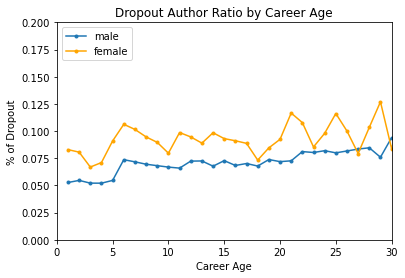

In [7]:
# exclude authors who enter APS publication after 2004
# create (JADIDI) scatterplot of dropout authors by career age

gb = prod[prod['year']['min'] < 2004].groupby(['gender', 'career_age'])['career_age'].count()

gb_m = gb['male'].sort_index(ascending=False)
gb_fm = gb['female'].sort_index(ascending=False)

(gb_m/gb_m.cumsum()).iloc[::-1].plot(style='.-')
(gb_fm/gb_fm.cumsum()).iloc[::-1].plot(style='.-',color='orange')

plt.title('Dropout Author Ratio by Career Age')
plt.legend(('male', 'female'), loc='upper left')
plt.xlabel('Career Age')
plt.xlim(0,30)
plt.ylabel('% of Dropout')
plt.ylim(0, 0.2)

## 4. Citation Analysis

### 4.1 Degree Centrality Analysis

In [ ]:
# exclude alphabetically ordered papers
# only consider primary authors
degcen = data.query('is_alpha == False & order == 1')

# calculate degree centrality per paper
vc = cb['cited_doi'].value_counts()
cb_sub = vc[vc.to_numpy() > 0].to_frame()

# create a DataFrame with degree centrality
cited = pd.merge(cb_sub, degcen, left_index = True, right_on = 'doi')

Text(0, 0.5, 'Proportion of Female Primary Authors')

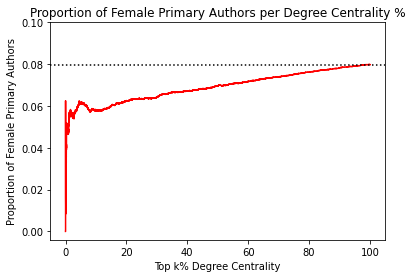

In [ ]:
# Comparative graph for actual female proportion vs. expected female proportion
cited_gender = cited['gender'].to_numpy()
cumulate_cited_gender = np.cumsum(cited_gender == "female")

plt.plot((np.arange(len(cited))*100)/len(cited), cumulate_cited_gender/np.arange(1, len(cited)+1), color='red')
plt.axhline(y=len(cited[cited['gender'] == 'female'])/len(cited), color='black', linestyle='dotted')

plt.title("Proportion of Female Primary Authors per Degree Centrality %")
plt.xlabel("Top k% Degree Centrality")
plt.ylim(ymax=0.1)
plt.ylabel("Proportion of Female Primary Authors")

### 4.2 Self-citation Analysis (general)


In [ ]:
# create a DataFrame with self-citing authors by gender
pop = cdata.groupby(['citing_year'])['citing_year'].count()

male = cdata.loc[cdata['citing_gender'] == 'male'].groupby(['citing_year'])['citing_year'].count()
female = cdata.loc[cdata['citing_gender'] == 'female'].groupby(['citing_year'])['citing_year'].count()

sccit = cdata.loc[cdata['citing_id'] == cdata['cited_id']].groupby(['citing_year'])['citing_year'].count()

malesc = cdata.loc[(cdata['citing_id'] == cdata['cited_id']) & (cdata['citing_gender'] == 'male')].groupby(['citing_year'])['citing_year'].count()
femalesc = cdata.loc[(cdata['citing_id'] == cdata['cited_id']) & (cdata['citing_gender'] == 'female')].groupby(['citing_year'])['citing_year'].count()

pop[np.isnan(pop)] = 0
male[np.isnan(male)] = 0
female[np.isnan(female)] = 0
sccit[np.isnan(sccit)] = 0
malesc[np.isnan(malesc)] = 0
femalesc[np.isnan(femalesc)] = 0

(0.0, 0.15)

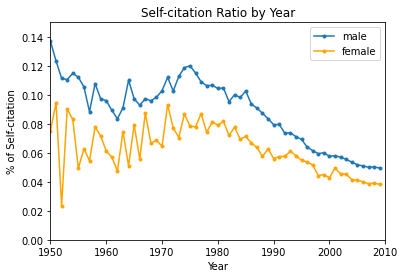

In [ ]:
# create a self-citation ratio plot by year
(malesc/male).plot(style='.-')
(femalesc/female).plot(style='.-',color='orange')

plt.title('Self-citation Ratio by Year')
plt.legend(('male', 'female'), loc='upper right')
plt.xlabel('Year')
plt.xlim(xmin=1950)
plt.xlim(xmax=2010)
plt.ylabel('% of Self-citation')
plt.ylim(ymin=0, ymax=0.15)

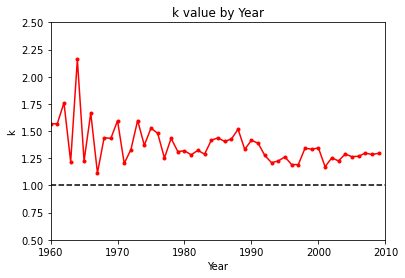

In [ ]:
# calculate k-value
k1 = ((malesc/sccit)/(femalesc/sccit))
k2 = ((female/pop)/(male/pop))
k = k1*k2

# create k-value plot
k.plot(style='.-', color='red')

plt.title('k value by Year')
plt.xlabel('Year')
plt.xlim(xmin=1960)
plt.xlim(xmax=2010)
plt.ylabel('k')
plt.ylim(ymin=0.5,ymax=2.5)
plt.hlines(1,xmin=1903,xmax=2010,linestyles='dashed')

## 5 PageRank Centrality

In [ ]:
# apply nx.graph to citation relationship network
Graphtype = nx.DiGraph()

C = nx.from_pandas_edgelist(cen, source='citing_doi',
                            target='cited_doi', create_using=Graphtype)
print(nx.info(C))

Name: 
Type: DiGraph
Number of nodes: 144813
Number of edges: 703005
Average in degree:   4.8546
Average out degree:   4.8546


In [ ]:
# observe author id & gender (primary author)
nodedata = data.query('is_alpha == False & order == 1').drop(
    ['order', 'numAuthor',	'is_last',	'is_alpha',	'year',
     'articleType',	'journal', 'id'], axis=1).reset_index()
nodedata.columns = ['id', 'Label', 'Gender']
nodedata.tail()

,id,Label,Gender
149622,531302,10.1103/PhysRevLett.98.068101,male
149623,531304,10.1103/PhysRevE.76.017301,female
149624,531305,10.1103/PhysRevSTPER.3.020101,male
149625,531310,10.1103/PhysRevSTPER.4.010102,male
149626,531311,10.1103/PhysRevSTPER.4.010108,male


In [ ]:
# assign PageRank centrality to each paper
pr = nx.pagerank(C)

# create a centrality dataframe
prs = pd.DataFrame()
prs['doi'] = pr.keys()
prs['centrality'] = pr.values()

# merge and create a dataframe: id, gender, PageRank centrality
prs_new = prs.merge(nodedata, left_on='doi', right_on='Label',
                how='left').drop(['doi', 'Label'], axis=1)
prs_new = prs_new[['id', 'Gender', 'centrality']].sort_values(
    'centrality', ascending=False)
prs_new.head()

,id,Gender,centrality
3189,43633,male,0.001368
25816,87360,male,0.001325
49819,187598,male,0.001062
54770,187575,male,0.000961
20116,91551,male,0.000918


Text(0, 0.5, 'Proportion of Female Primary Authors')

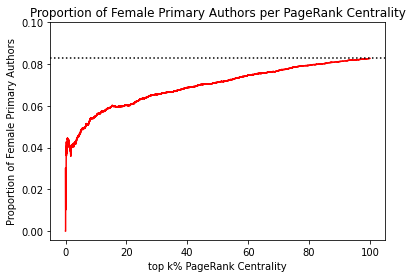

In [ ]:
# Comparative graph for actual female proportion vs. expected female proportion

prs_gender = prs_new['Gender'].to_numpy()
cumulate_prs_gender = np.cumsum(prs_gender == "female")

plt.plot((np.arange(len(prs_new))*100)/len(prs_new),
         cumulate_prs_gender/np.arange(1, len(prs_new)+1), color='red')
plt.axhline(y=0.08274119036274367, color='black', linestyle='dotted')

plt.title("Proportion of Female Primary Authors per PageRank Centrality")
plt.xlabel("top k% PageRank Centrality")
plt.ylim(ymax=0.1)
plt.ylabel("Proportion of Female Primary Authors")

## 5.1 PageRank Centrality among Similar Papers

In [ ]:
############## SELECT DESIRED PACS (HOMOPHILY ONLY) ###############

homn = pd.read_csv("drive/My Drive/codes/hom0.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom1.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom2.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom3.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom4.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom5.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom6.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom7.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom8.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom9.csv")

print(len(homn))
homn.head()

1189255


,paper1,gender1,year1,paper2,gender2,year2,qval,k
0,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.1617,male,1986,0.001230,False
1,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.4472,female,1986,0.017857,False
2,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.41.784,male,1990,0.017857,False
3,10.1103/PhysRevA.34.4472,female,1986,10.1103/PhysRevA.41.784,male,1990,0.017857,False
4,10.1103/PhysRevA.36.4950,female,1987,10.1103/PhysRevA.41.784,male,1990,0.006410,False


In [ ]:
# Calculate cen_d (male centrality - female centrality)

prs_sim = prs.merge(nodedata, left_on='doi', right_on='Label',
                    how='left').drop(['Label'], axis=1)
prs_sim = prs_sim[["doi", 'id', 'Gender', 'centrality']].sort_values(
    'centrality', ascending=False)

ph = pd.merge(homn, prs_sim, left_on = "paper1", right_on = "doi", how = "left")
ph = ph.drop(["doi", "id", "Gender"], axis=1)
ph = ph.rename(columns={"centrality": "cen1"})

ph = ph.merge(prs_sim, left_on = "paper2", right_on = "doi", how = "left")
ph = ph.drop(["doi", "id", "Gender"], axis=1)
ph = ph.rename(columns={"centrality": "cen2"})
print(len(ph))

ph = ph[ph['gender1'] != ph['gender2']].reset_index(drop=True)

listd = []

for c in range(len(ph)):
  if ph['gender1'][c] == 'male':
    listd.append(ph['cen1'][c] - ph['cen2'][c])
  else:
    listd.append(ph['cen2'][c] - ph['cen1'][c])

ph['cen_d'] = listd

print(len(ph))
ph.head()

1189255
184694


,paper1,gender1,year1,paper2,gender2,year2,qval,k,cen1,cen2,cen_d
0,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.4472,female,1986,0.017857,False,0.000018,0.000004,1.402271e-05
1,10.1103/PhysRevA.34.4472,female,1986,10.1103/PhysRevA.41.784,male,1990,0.017857,False,0.000004,0.000005,7.764608e-07
2,10.1103/PhysRevA.36.4950,female,1987,10.1103/PhysRevA.41.784,male,1990,0.006410,False,0.000002,0.000005,2.824713e-06
3,10.1103/PhysRevA.39.5466,female,1989,10.1103/PhysRevA.41.784,male,1990,0.006410,False,0.000002,0.000005,2.166712e-06
4,10.1103/PhysRevA.41.3081,female,1990,10.1103/PhysRevA.41.784,male,1990,0.000511,False,0.000002,0.000005,2.824713e-06


In [ ]:
# Extract subDataFrame with q-value less than p threshold

p = 0.002 # Select p thresholds with listed numbers in the paper

phsub = ph[ph['qval'] < p].sort_values('cen_d').reset_index(drop=True)

mlist = []
fmlist = []

for i in range(len(phsub)):
  if phsub['gender1'][i] == 'male':
    mlist.append(phsub['cen1'][i])
    fmlist.append(phsub['cen2'][i])
  else:
    mlist.append(phsub['cen2'][i])
    fmlist.append(phsub['cen1'][i])

# Find the standard deviation
sd = math.sqrt((np.std(mlist) ** 2 + np.std(fmlist) ** 2)/len(phsub))

# Find z-scores (for p-values)
print((np.mean(mlist)-np.mean(fmlist))/sd)

-0.6457704432323805
